# 代码实现

我们来编写$k$均值算法，并利用RGB值对图像进行分割。先导入一张图像。


In [1]:
from sklearn.cluster import KMeans
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# 输入一张图像，图像来源于参考文献[5]
image = imread('segmentation.jpeg')[:,:,:3]
# 将RGB值统一到0-1内
if np.max(image)>1:
    image = image / 255

X = image.reshape(-1, image.shape[2])


In [2]:
# 利用k-means算法进行聚类
segmented_imgs = []

# 设定聚类中心个数
n_cluster= 4
kmeans = KMeans(n_clusters=n_cluster, random_state=42).fit(X)
print(np.unique(kmeans.labels_))

[0 1 2 3]


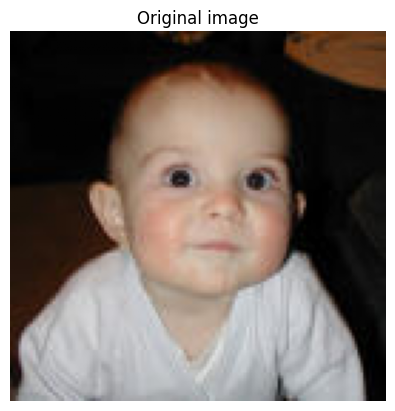

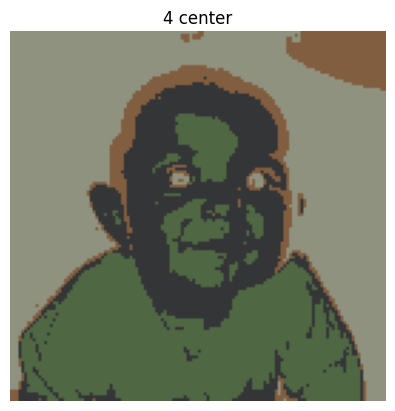

In [3]:
# 为每一个类别赋予一个对应的颜色，用于展示
def decode_segmap(label_mask, plot=False):
    label_colours = np.asarray([[79, 103, 67], [143, 146, 126], 
                                [129, 94, 64], [52, 53, 55],
                                [96, 84, 70], [164, 149, 129]])
    r = label_mask.copy()
    g = label_mask.copy()
    b = label_mask.copy()
    # 为每个类别赋予对应的R、G、B值
    for ll in range(0, 6):
        r[label_mask == ll] = label_colours[ll, 0]
        g[label_mask == ll] = label_colours[ll, 1]
        b[label_mask == ll] = label_colours[ll, 2]

    rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
    rgb[:, :, 0] = r
    rgb[:, :, 1] = g
    rgb[:, :, 2] = b

    return rgb


# 获得预测的标签
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_imgs = decode_segmap(kmeans.labels_.reshape(
                        image.shape[0],image.shape[1]))

# 展示结果
plt.imshow(image[:,:,:3])
plt.title('Original image')
plt.axis('off')
plt.show()

plt.imshow(segmented_imgs.astype(np.uint8))
plt.title('{} center'.format(n_cluster))
plt.axis('off')
plt.show()

再次动手尝试图像分割，并比较设置不同个数的聚类中心对图像分割的影响。

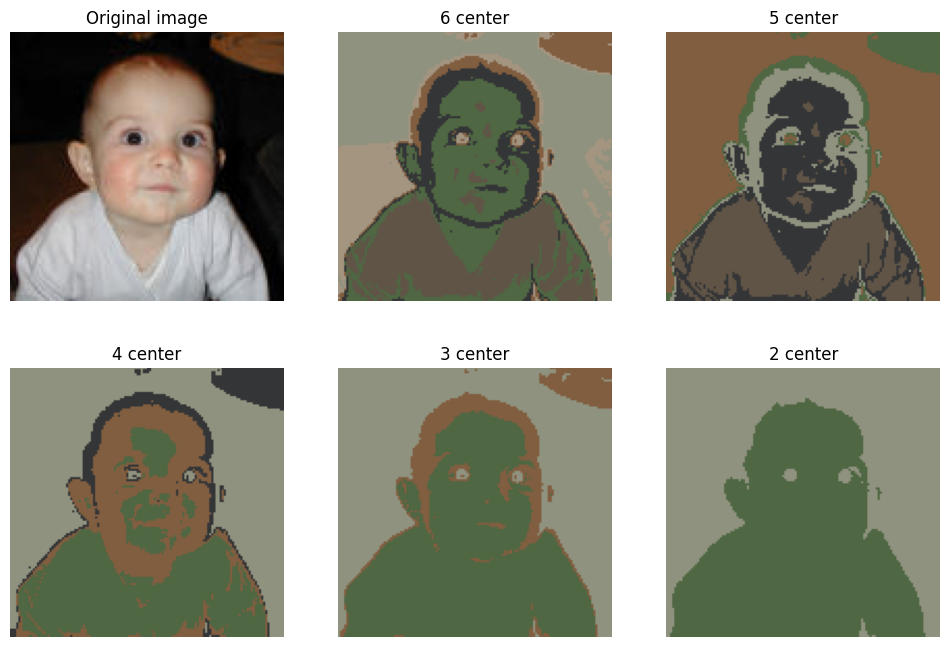

In [4]:
image = imread('segmentation.jpeg')[:,:,:3]
# 将RGB值统一到0-255内
if np.max(image)>1:
    image = image / 255
    

sp = image.shape
# 增加xy坐标的信息
# 设定一个权重，对坐标信息加权
weight = 2
y = weight * np.array([[i for i in range(sp[1])] 
                       for j in range(sp[0])]) / sp[0] / sp[1]
x = weight * np.array([[j for i in range(sp[1])] 
                       for j in range(sp[0])])/ sp[0] / sp[1]
image = np.append(image, x.reshape(sp[0], sp[1], 1), axis=2)
image = np.append(image, y.reshape(sp[0], sp[1], 1), axis=2)

X = image.reshape(-1, image.shape[2])
segmented_imgs = []

# 将 K 分别设置为6、5、4、3、2
n_colors = (6, 5, 4, 3, 2)
for n_cluster in n_colors:
    kmeans = KMeans(n_clusters=n_cluster, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(decode_segmap(
        kmeans.labels_.reshape(image.shape[0],
                               image.shape[1])).astype(np.uint8))

# 展示结果
plt.figure(figsize=(12,8))
plt.subplot(231)
plt.imshow(image[:,:,:3])
plt.title('Original image')
plt.axis('off')

for idx,n_clusters in enumerate(n_colors):
    plt.subplot(232+idx)
    plt.imshow(segmented_imgs[idx])
    plt.title('{} center'.format(n_clusters))
    plt.axis('off')



接下来，我们将动手编程实现归一化图切割算法。

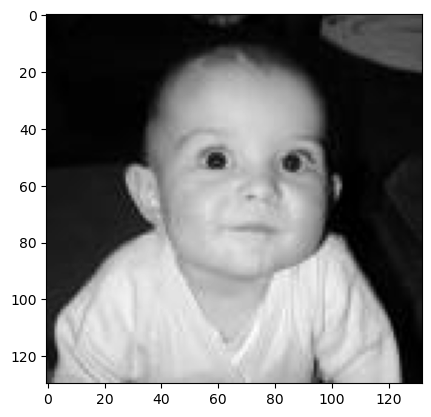

In [1]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

sample_img = cv2.imread('segmentation.jpeg', cv2.IMREAD_GRAYSCALE).astype(
                                                np.float32) / 255
plt.imshow(sample_img, cmap='gray')

我们接着编写权重矩阵。

In [2]:
def cal_dist_weighted_matrix(size, r, sig_X):
    h, w = size
    X_matrix = np.zeros((h*w, h*w))
    for i in range(h*w):
        for j in range(h*w):
            i_row, i_col = i // w, i % w
            j_row, j_col = j // w, j % w
            dist = np.power(i_row - j_row, 2) + \
                np.power(i_col - j_col, 2)
            
            if np.sqrt(dist) < r:    
                X_matrix[i, j] = np.exp(-dist / sig_X)
    return X_matrix
    
    
def set_weighted_matrix(img, sig_I=0.01, sig_X=5, r=10):
    vec_img = img.flatten()
    F_matrix = np.power(vec_img[None, :] - vec_img[:, None], 2)
    F_matrix /= sig_I
    F_matrix = np.exp(-F_matrix)
    
    X_matrix = cal_dist_weighted_matrix(img.shape, r, sig_X)
    return F_matrix * X_matrix


weighted_matrix = set_weighted_matrix(sample_img)

weighted_matrix

array([[1.        , 0.81873075, 0.44863849, ..., 0.        , 0.        ,
        0.        ],
       [0.81873075, 1.        , 0.81747264, ..., 0.        , 0.        ,
        0.        ],
       [0.44863849, 0.81747264, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.81873075,
        0.44863849],
       [0.        , 0.        , 0.        , ..., 0.81873075, 1.        ,
        0.81747264],
       [0.        , 0.        , 0.        , ..., 0.44863849, 0.81747264,
        1.        ]])

接着求解每一个特征值对应的特征向量。

In [3]:
from scipy import sparse
from scipy.sparse.linalg import eigs, svds
import skimage

def n_cuts(W, image):
    n = W.shape[0]
    s_D = sparse.csr_matrix((n, n))
    d_i = W.sum(axis=0)
    for i in range(n):
        s_D[i, i] = d_i[i]
    s_W = sparse.csr_matrix(W)
    # print(s_W.shape)
    s_D_nhalf = np.sqrt(s_D).power(-1)
    # print(s_D.shape)

    L = s_D_nhalf @ (s_D - s_W) @ s_D_nhalf
    # print(L.shape)

    _, eigenvalues, eigenvectors = svds(L, which='SM')
    print(eigenvectors.shape)

    for i in range(1, 5):
        print(eigenvectors[i].shape)
        Partition = eigenvectors[i] > \
            np.sum(eigenvectors[i])/len(eigenvectors[i])
        print(Partition.shape)
        skimage.io.imshow(Partition.reshape(image.shape))
        plt.title('Ncut')
        plt.show()

展示相应的分割结果。

In [ ]:
n_cuts(weighted_matrix, sample_img)

<center>
    <img style="border-radius: 0.3125em;" 
    src="https://pic1.zhimg.com/80/v2-31642a71d6d95f791284a142399d1800_1440w.webp" width=400>
    <br>
    <div style="color:orange; 
    display: inline-block;
    color: #999;
    padding: 2px;"></div>
</center>